# Cell 1: Imports

In [1]:
import pandas as pd
import numpy as np
import re
import emoji
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# --- TAMBAHAN: Import library untuk preprocessing ---
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cell 2: Inisialisasi Sastrawi

In [2]:
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# --- Buat objek stopword remover ---
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

# 1. Load Dataset & Lexicons

In [5]:
# Cell 4: Load Data
print("=== [1] Load Dataset & Lexicons ===")
df = pd.read_csv("datasets_raw/datasets_fomo_10000_nolabel.csv")
print(f"Jumlah data awal: {len(df)}")

# Load slang lexicon
slang_df = pd.read_csv("dict/colloquial-indonesian-lexicon.csv")
slang_dict = dict(zip(slang_df['slang'], slang_df['formal']))

# Load positive & negative lexicon
positive_lexicon = pd.read_csv("lexicon/positive.tsv", sep="\t", header=None, names=["word", "label"])
negative_lexicon = pd.read_csv("lexicon/negative.tsv", sep="\t", header=None, names=["word", "label"])
positive_words = set(positive_lexicon['word'].tolist())
negative_words = set(negative_lexicon['word'].tolist())

=== [1] Load Dataset & Lexicons ===
Jumlah data awal: 9546


# 2. Preprocessing Functions

In [6]:
def clean_text(text):
    # Pastikan tipe string
    text = str(text).lower()
    # Hapus URL
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Hapus mention dan hashtag (opsional, tergantung konteks)
    text = re.sub(r"@\w+", "", text)  # hapus mention @username
    text = re.sub(r"#\w+", "", text)  # hapus hashtag
    # Hapus emoji
    text = emoji.replace_emoji(text, replace='')
    # Ganti angka dengan placeholder (opsional, biar tidak hilang makna seperti "covid19")
    text = re.sub(r"\d+", " ", text)
    # Hilangkan karakter non-alfabet (kecuali spasi)
    text = re.sub(r"[^a-z\s]", " ", text)
    # Hapus kata dengan satu huruf (biasanya noise, kecuali "a" atau "i" dalam English)
    text = re.sub(r"\b[a-z]\b", " ", text)
    # Hapus pengulangan huruf berlebih (contoh: “baguuuusss” → “bagus”)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    # Hapus spasi berlebih
    text = re.sub(r"\s+", " ", text).strip()

    return text
def normalize_slang(text, slang_dict):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return " ".join(normalized_words)

def remove_stopwords(text):
    return stopword_remover.remove(text)

def stem_text(text):
    return stemmer.stem(text)
# ---------------------------------------------------------

def lexicon_label(text):
    words = text.split()
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    if pos_count > neg_count:
        return "positive"
    elif neg_count > pos_count:
        return "negative"
    else:
        return "neutral"

# 3. Load IndoBERT Sentiment Model

In [7]:
print("\n=== [3] Load IndoBERT Sentiment Model ===")
pretrained = "mdhugol/indonesia-bert-sentiment-classification"
model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}

def indobert_label_with_score(text):
    try:
        result = sentiment_pipeline(text[:512])[0]
        label = label_index[result['label']]
        score = result['score']
        return label, score
    except:
        return "neutral", 0.0


=== [3] Load IndoBERT Sentiment Model ===


Device set to use cuda:0


# 4. Apply Preprocessing

In [8]:
# Cell 10: Run Preprocessing Pipeline
print("\n=== [4] Preprocessing & Labeling (Pipeline Lengkap) ===")
tqdm.pandas()

# 1. Cleaning & Normalisasi (Dasar untuk semua)
print("Tahap 1: Membersihkan dan menormalisasi teks...")
df['text_clean'] = df['full_text'].progress_apply(clean_text)
df['text_clean'] = df['text_clean'].progress_apply(lambda x: normalize_slang(x, slang_dict))

# 2. Stopword Removal & Stemming (LEXICON)
print("\nTahap 2: Membuat teks versi stemmed untuk analisis leksikon...")
df['text_lexicon'] = df['text_clean'].progress_apply(remove_stopwords)
df['text_lexicon'] = df['text_lexicon'].progress_apply(stem_text)

# 3. Prediksi dengan IndoBERT (menggunakan text_clean)
print("\nTahap 3: Melakukan prediksi sentimen dengan IndoBERT...")
df[['label_model', 'model_conf']] = df['text_clean'].progress_apply(
    lambda x: pd.Series(indobert_label_with_score(x))
)

# 4. Prediksi dengan Lexicon
print("\nTahap 4: Melakukan prediksi sentimen dengan metode leksikon...")
df['label_lexicon'] = df['text_lexicon'].progress_apply(lexicon_label)

print("\nContoh hasil preprocessing dan labeling:")
print(df[['text_clean', 'text_lexicon', 'label_model', 'model_conf', 'label_lexicon']].head(10))


=== [4] Preprocessing & Labeling (Pipeline Lengkap) ===
Tahap 1: Membersihkan dan menormalisasi teks...


100%|██████████| 9546/9546 [00:00<00:00, 210976.06it/s]



Tahap 2: Membuat teks versi stemmed untuk analisis leksikon...


100%|██████████| 9546/9546 [12:16<00:00, 12.96it/s] 



Tahap 3: Melakukan prediksi sentimen dengan IndoBERT...


100%|██████████| 9546/9546 [02:13<00:00, 71.55it/s]



Tahap 4: Melakukan prediksi sentimen dengan metode leksikon...


100%|██████████| 9546/9546 [00:00<00:00, 214393.41it/s]


Contoh hasil preprocessing dan labeling:
                                          text_clean  \
0  suara jaehyun tuh tipe suara yang pengin kamu ...   
1  lucu banget melihat kalian pada takut tidur al...   
2  yaampun kak aku auto lihat jam takut ketinggal...   
3      mau bobo tapi takut ketinggalan sesuatu nanti   
4                                  takut ketinggalan   
5  okey siap beberapa hari kedepan enggak boleh t...   
6  lagian sekelas wamen marah dan nyuruh nya kok ...   
7  ada orang ngerjain skripsi selalu di cafe demi...   
8  upload foto survei ada beberapa yang reply itu...   
9  sumpah kagak tau ini juga dari moots aku makan...   

                                        text_lexicon label_model  model_conf  \
0  suara jaehyun tuh tipe suara pengin kamu denga...    positive    0.794657   
1  lucu banget lihat kalian takut tidur alias tak...    positive    0.687932   
2  yaampun kak aku auto lihat jam takut tinggal t...     neutral    0.808981   
3                    

# 4.1. Ekspor Hasil Model Saja (Untuk Perbandingan)

In [14]:
print("\n=== [Tahap 4.1] Menyimpan Hasil Khusus dari Model IndoBERT ===\n")
df_model_only = df[['full_text', 'text_clean', 'text_lexicon', 'label_model', 'model_conf']].copy()
df_model_only.rename(columns={'label_model': 'sentiment'}, inplace=True)
output_path_model_only = "datasets/results_model_only_for_comparison_2.csv"
df_model_only.to_csv(output_path_model_only, index=False)

print(f"✅ Hasil dari model saja (tanpa hybrid) berhasil disimpan ke: {output_path_model_only}")
print("\nContoh data yang disimpan:")
print(df_model_only.head())


=== [Tahap 4.1] Menyimpan Hasil Khusus dari Model IndoBERT ===

✅ Hasil dari model saja (tanpa hybrid) berhasil disimpan ke: datasets/results_model_only_for_comparison_2.csv

Contoh data yang disimpan:
                                           full_text  \
0  suara jaehyun tuh tipe suara yg pengen km deng...   
1  LUCU BANGET NGELIAT KALIAN PADA TAKUT TIDURRR ...   
2  @catchingdoie yaampun kak aku auto liat jam ta...   
3        mau bobo tp takut ketinggalan sesuatu nanti   
4                                  takut ketinggalan   

                                          text_clean  \
0  suara jaehyun tuh tipe suara yang pengin kamu ...   
1  lucu banget melihat kalian pada takut tidur al...   
2  yaampun kak aku auto lihat jam takut ketinggal...   
3      mau bobo tapi takut ketinggalan sesuatu nanti   
4                                  takut ketinggalan   

                                        text_lexicon sentiment  model_conf  
0  suara jaehyun tuh tipe suara pengin kamu de

# 5. EDA (Distribusi Confidence & Label)


=== [5] EDA (Distribusi Confidence & Label) ===


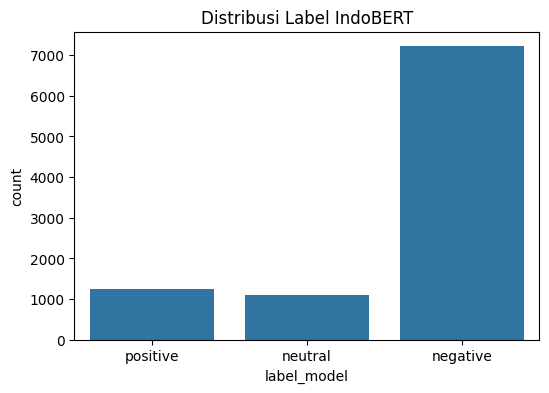

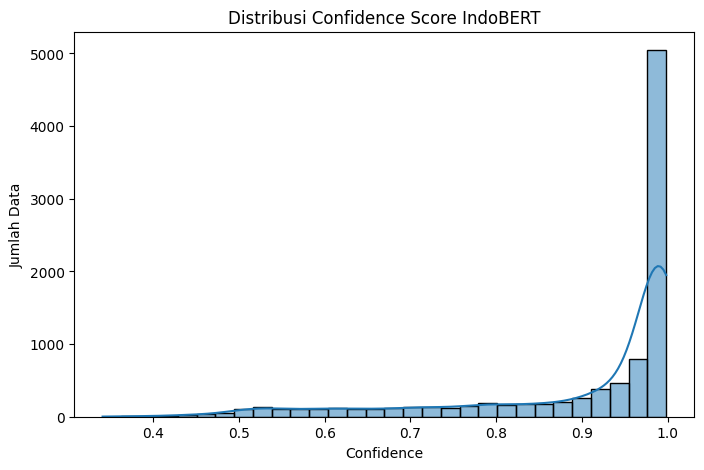

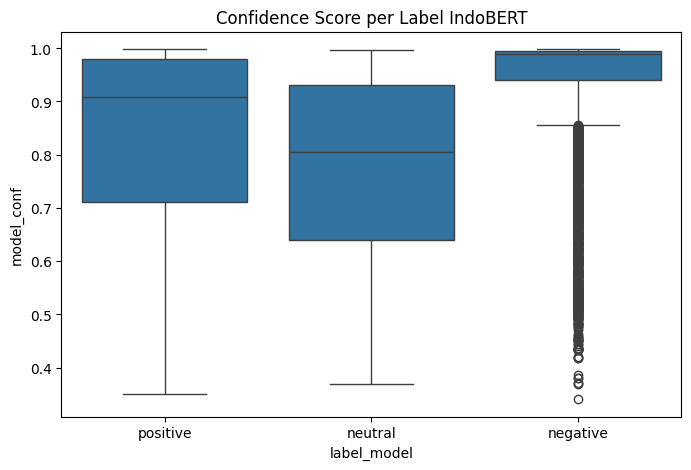

In [10]:
# Cell 13: EDA Visualizations
print("\n=== [5] EDA (Distribusi Confidence & Label) ===")
plt.figure(figsize=(6,4))
sns.countplot(x='label_model', data=df)
plt.title("Distribusi Label IndoBERT")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df['model_conf'], bins=30, kde=True)
plt.title("Distribusi Confidence Score IndoBERT")
plt.xlabel("Confidence")
plt.ylabel("Jumlah Data")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='label_model', y='model_conf', data=df)
plt.title("Confidence Score per Label IndoBERT")
plt.show()


# 6. Hybrid Labeling with Threshold

In [15]:
print("\\n=== [6] Hybrid Labeling with Threshold ===")
HIGH_CONF = 0.61  # Dianalisis dari hasil presentil 75%

def hybrid_labeling(row):
    model_label = row['label_model']
    model_score = row['model_conf']
    lex_label = row['label_lexicon']

    # 1. Jika model sangat yakin, langsung gunakan labelnya.
    if model_score >= HIGH_CONF:
        return model_label, "valid"

    # 2. Jika model tidak yakin, periksa dengan leksikon.
    if model_score < HIGH_CONF:
        # KASUS PERUBAHAN: Model netral, leksikon ada sentimen -> Tandai ambigu
        if lex_label in ["positive", "negative"] and model_label == "neutral":
            return model_label, "ambiguous"  # <<< PERUBAHAN DI SINI

        # Model ada sentimen, leksikon netral -> Percaya model
        elif model_label in ["positive", "negative"] and lex_label == "neutral":
            return model_label, "valid"

        # Keduanya setuju -> Valid
        elif lex_label == model_label:
            return model_label, "valid"
            
        # Keduanya tidak setuju (misal: pos vs neg) -> Sangat ambigu
        else:
            return None, "ambiguous"

# Terapkan fungsi ke DataFrame
df[['final_label', 'status']] = df.progress_apply(hybrid_labeling, axis=1, result_type="expand")

print("Proses pelabelan hibrida selesai.")

\n=== [6] Hybrid Labeling with Threshold ===


100%|██████████| 9546/9546 [00:00<00:00, 23048.57it/s]

Proses pelabelan hibrida selesai.


# 7. Analisis Distribusi Final Label


Distribusi final label:
final_label
negative    7152
positive    1125
neutral     1087
None         182
Name: count, dtype: int64

Jumlah valid: 9213 | Jumlah ambiguous: 333

✅ Proses selesai! File disimpan.

Jumlah Data Valid per Threshold:
   Threshold  Jumlah_Data
0        0.6         8866
1        0.7         8337
2        0.8         7667
3        0.9         6840


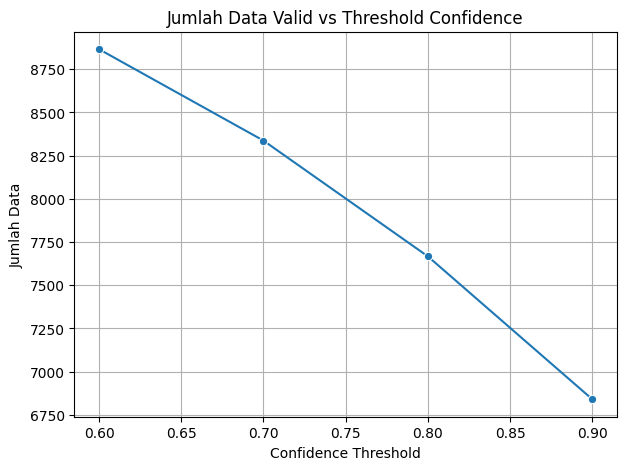

In [16]:
# Cell 17: Final Analysis and Export
print("\nDistribusi final label:")
print(df['final_label'].value_counts(dropna=False))

df_valid = df[df['status'] == "valid"]
df_ambiguous = df[df['status'] == "ambiguous"]

print(f"\nJumlah valid: {len(df_valid)} | Jumlah ambiguous: {len(df_ambiguous)}")

# Simpan hasil
df_valid.to_csv("datasets/train_ready_3class_10000_3.csv", index=False)
df_ambiguous.to_csv("datasets/ambiguous_3class_10000_3.csv", index=False)

print("\n✅ Proses selesai! File disimpan.")

# Cell 18: Threshold Analysis
thresholds = [0.6, 0.7, 0.8, 0.9]
results = []
for t in thresholds:
    valid_count = len(df[df['model_conf'] >= t])
    results.append((t, valid_count))

threshold_df = pd.DataFrame(results, columns=['Threshold', 'Jumlah_Data'])
print("\nJumlah Data Valid per Threshold:")
print(threshold_df)

# Visualisasi threshold vs jumlah data
plt.figure(figsize=(7,5))
sns.lineplot(x='Threshold', y='Jumlah_Data', data=threshold_df, marker='o')
plt.title("Jumlah Data Valid vs Threshold Confidence")
plt.xlabel("Confidence Threshold")
plt.ylabel("Jumlah Data")
plt.grid(True)
plt.show()

# 8. Data Balancing ( Parafraser ) ( No Hybrid Labeling )

In [5]:
import pandas as pd
import torch
from tqdm.auto import tqdm
import itertools
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [6]:

try:
    df = pd.read_csv('./datasets/results_model_only_for_comparison.csv')
    print("Distribusi kelas awal:")
    print(df['sentiment'].value_counts())
except FileNotFoundError:
    print("File 'results_model_only_for_comparison.csv' tidak ditemukan.")
    exit()

# --- 2. Inisialisasi Model Parafrasa ---
print("\nMemuat model dan tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("Wikidepia/IndoT5-base-paraphrase")
model = AutoModelForSeq2SeqLM.from_pretrained("Wikidepia/IndoT5-base-paraphrase")
print("Model berhasil dimuat.")

# --- 3. Tentukan Kelas Mayoritas ---
sentiment_counts = df['sentiment'].value_counts()
majority_class = sentiment_counts.idxmax()
max_count = sentiment_counts.max()
print(f"\nKelas mayoritas adalah '{majority_class}' dengan {max_count} sampel.")

new_rows = []

# --- 4. Proses Oversampling dengan Parafrasa ---
for sentiment in sentiment_counts.index:
    if sentiment != majority_class:
        subset_df = df[df['sentiment'] == sentiment]
        num_to_generate = max_count - len(subset_df)

        if num_to_generate == 0:
            continue

        print(f"\nMenghasilkan {num_to_generate} sampel baru untuk kelas '{sentiment}'...")

        # Gunakan iterator untuk mengulang kalimat jika jumlah yang dibutuhkan lebih banyak
        text_iterator = itertools.cycle(subset_df['full_text'].tolist())

        # Gunakan tqdm untuk melihat progress bar
        for _ in tqdm(range(num_to_generate), desc=f"Generating for {sentiment}"):
            original_sentence = next(text_iterator)
            text_to_paraphrase = "paraphrase: " + original_sentence + " </s>"

            # Encoding teks
            encoding = tokenizer(text_to_paraphrase, padding='longest', return_tensors="pt")
            input_ids = encoding["input_ids"]
            attention_mask = encoding["attention_mask"]

            # Hasilkan parafrasa
            try:
                outputs = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=256,  # Batasi panjang untuk efisiensi
                    do_sample=True,
                    top_k=150,
                    top_p=0.9,
                    early_stopping=True,
                    num_return_sequences=1
                )
                paraphrased_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

                # Tambahkan hasil ke list
                new_rows.append({
                    'full_text': paraphrased_sentence,
                    'text_clean': '',
                    'text_lexicon': '',
                    'sentiment': sentiment,
                    'model_conf': 'generated_paraphrase'
                })
            except Exception as e:
                print(f"Error saat memproses kalimat: '{original_sentence}'. Error: {e}")


# --- 5. Gabungkan dan Simpan Dataset Baru ---
if new_rows:
    new_rows_df = pd.DataFrame(new_rows)
    balanced_df = pd.concat([df, new_rows_df], ignore_index=True)
else:
    balanced_df = df.copy()

print("\nDistribusi kelas setelah penyeimbangan:")
print(balanced_df['sentiment'].value_counts())

# Simpan ke file CSV baru
output_filename = 'balanced_dataset.csv'
balanced_df.to_csv(output_filename, index=False)
print(f"\nDataset yang seimbang telah disimpan ke '{output_filename}'")

Distribusi kelas awal:
sentiment
negative    6663
neutral     1613
positive    1270
Name: count, dtype: int64

Memuat model dan tokenizer...
Model berhasil dimuat.

Kelas mayoritas adalah 'negative' dengan 6663 sampel.

Menghasilkan 5050 sampel baru untuk kelas 'neutral'...


Generating for neutral:   0%|          | 0/5050 [00:00<?, ?it/s]c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Generating for neutral:   1%|          | 39/5050 [00:58<2:05:17,  1.50s/it]


KeyboardInterrupt: 